In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import ast

In [58]:
file = open("../clearout_prices.txt", "r")
contents = file.read()
dictionary = ast.literal_eval(contents)
file.close()
df_raw = pd.DataFrame.from_dict(dictionary)

print(df_raw.head(5))
print(df_raw.dtypes)
print(df_raw.shape)

                            date  period   price   volume
0  Sun, 14 Mar 2021 00:00:00 GMT       1  32.105  1082.15
1  Sun, 14 Mar 2021 00:00:00 GMT       2  30.490  1146.95
2  Sun, 14 Mar 2021 00:00:00 GMT       3  20.635  1134.00
3  Sun, 14 Mar 2021 00:00:00 GMT       4  17.140  1142.20
4  Sun, 14 Mar 2021 00:00:00 GMT       5  25.750  1495.30
date       object
period      int64
price     float64
volume    float64
dtype: object
(624, 4)


In [29]:
def tidy_df(df):
    df_proc = df.copy()
    for i in range (0,len(df)):
        df.loc[i,'date']= pd.to_datetime(pd.to_datetime(df.loc[i,'date']) + pd.Timedelta(hours=int(df.loc[i,'period'])))
    df_proc['date'] = pd.DatetimeIndex(df['date'])
    df_proc.drop(columns=['period'], inplace = True)
    df_proc.set_index('date', inplace = True)
    df_proc.resample('W').mean()
    df_proc.fillna(df.mean())
    return df_proc  

<ipython-input-29-ce0be2d491f2>:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_proc.fillna(df.mean())


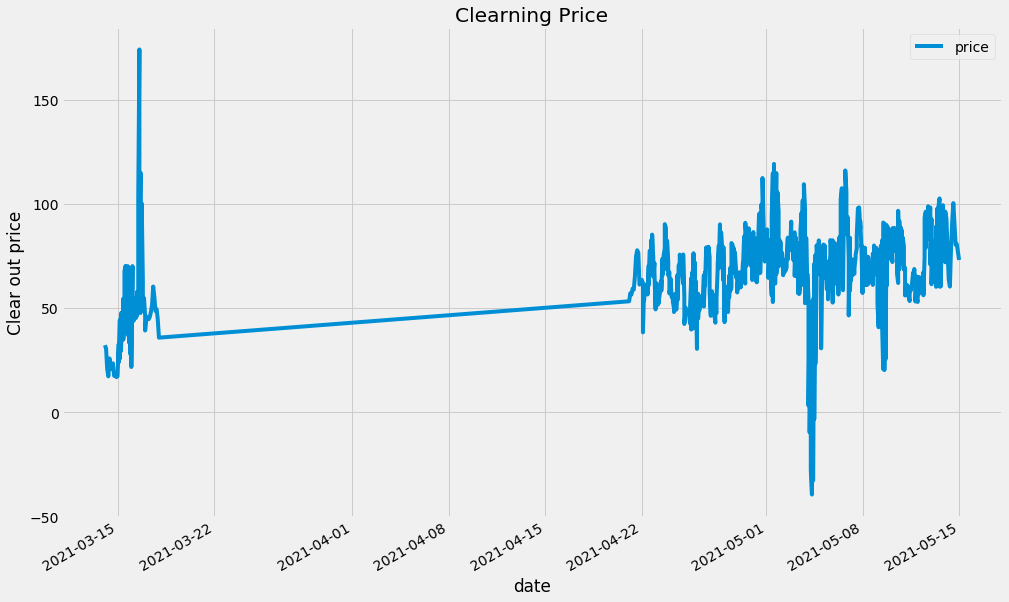

In [30]:
df_proc = tidy_df(df)

plt.figure(figsize=(15,10))
plt.style.use('fivethirtyeight')
df_proc['price'].plot()
plt.legend()
plt.title("Clearning Price")
plt.ylabel('Clear out price')
plt.show()

In [32]:
dataset = df.iloc[:,0:2].values

In [33]:
dataset.shape

(624, 2)

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = dataset[:,0]
y = dataset[:,1]
y = scaler.fit_transform(y.reshape(-1,1))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [36]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [37]:
train_X, train_y = create_dataset(y_train)
test_X, test_y =  create_dataset(y_test)

In [39]:
print(train_X.shape, train_y.shape)

(466, 1) (466,)


In [40]:
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [44]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
466/466 - 1s - loss: 0.1592
Epoch 2/10
466/466 - 0s - loss: 0.0926
Epoch 3/10
466/466 - 0s - loss: 0.0916
Epoch 4/10
466/466 - 0s - loss: 0.0915
Epoch 5/10
466/466 - 0s - loss: 0.0905
Epoch 6/10
466/466 - 0s - loss: 0.0909
Epoch 7/10
466/466 - 0s - loss: 0.0906
Epoch 8/10
466/466 - 0s - loss: 0.0905
Epoch 9/10
466/466 - 0s - loss: 0.0905
Epoch 10/10
466/466 - 0s - loss: 0.0904


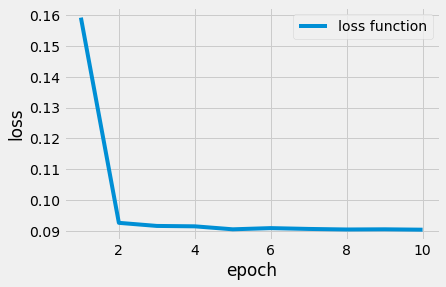

In [51]:
plt.figure()
plt.plot(np.arange(1,11), history.history['loss'], label="loss function")
plt.xlabel("epoch")
plt.ylabel('loss')
plt.legend()
plt.show()

In [59]:
y_pred_train = scaler.inverse_transform(model.predict(train_X))
y_pred_test  = scaler.inverse_transform(model.predict(test_X))

In [60]:
print(y_pred_train.shape, train_X.shape)

(466, 1) (466, 1, 1)


In [66]:
pred_df = pd.DataFrame(columns = ['date', 'test_set','prediction'])
date_ind = np.array(df.loc[470:624,'date'])
period = np.array(df.loc[470:624,'period'])
pred_df['date'] = date_ind
pred_df['period'] = period
pred_df['test_set'] = np.array(scaler.inverse_transform(test_X.reshape(154,1))).reshape(154)
pred_df['prediction'] = np.array(y_pred_test.reshape(154,1)).reshape(154)
df_to_plot = tidy_df(pred_df)


<ipython-input-29-ce0be2d491f2>:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_proc.fillna(df.mean())


<Figure size 1080x864 with 0 Axes>

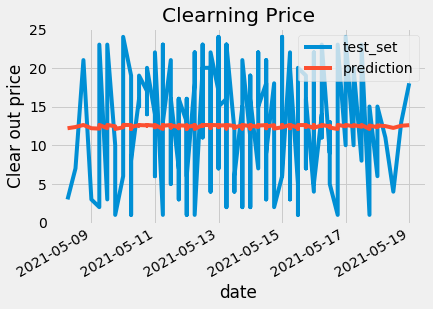

In [67]:
plt.figure(figsize=(15,12))
plt.style.use('fivethirtyeight')
df_to_plot.plot()
plt.legend()
plt.title("Clearning Price")
plt.ylabel('Clear out price')
plt.show()